# Case Study: Regression Analysis
Ashwin John Chempolil, <br>
Hemanth Reddy Musuku, <br>
Raja Muthu, <br>
Sowmya Shree Nagaraju <br>

In [1]:
# Importing all the libraries
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
%matplotlib inline

In [2]:
# reading the board_games.csv 
board_games = pd.read_csv('board_games.csv')
# printing out first few rows of the data
board_games.head()

,id,name,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
0,12333,Twilight Struggle,2005.0,2.0,2.0,180.0,180.0,180.0,13.0,20113,8.33774,26647,372,1219,5865,5347,2562,3.4785
1,120677,Terra Mystica,2012.0,2.0,5.0,150.0,60.0,150.0,12.0,14383,8.28798,16519,132,1586,6277,2526,1423,3.8939
2,102794,Caverna: The Cave Farmers,2013.0,1.0,7.0,210.0,30.0,210.0,12.0,9262,8.28994,12230,99,1476,5600,1700,777,3.7761
3,25613,Through the Ages: A Story of Civilization,2006.0,2.0,4.0,240.0,240.0,240.0,12.0,13294,8.20407,14343,362,1084,5075,3378,1642,4.1590
4,3076,Puerto Rico,2002.0,2.0,5.0,150.0,90.0,150.0,12.0,39883,8.14261,44362,795,861,5414,9173,5213,3.2943


In [3]:
# Removing rows that contain missing values
board_games.dropna(axis=0,inplace=True)

In [4]:
# Removing rows that have no reviews
board_games = board_games[-(board_games['users_rated']==0)]

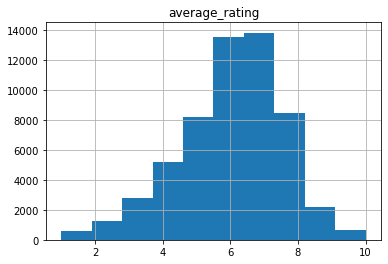

In [5]:
board_games.hist('average_rating');

In [6]:
print (f'The standard deviation of average_rating column : {board_games["average_rating"].std():.3f}')

The standard deviation of average_rating column : 1.579


In [7]:
print (f'The mean of average_rating column : {board_games["average_rating"].mean():.3f}')

The mean of average_rating column : 6.016


From the plot, and the values of the mean and standard deviation, it is apparent that there are almost no outliers here.Hence, we would recommend using SSE or RMSE as error metric, as there are no significant outliers that might have an adverse effect on the fit of the model.

In [8]:
# Use the corr method on numeric_columns to compute correlations between columns. Assign the result to correlations 
correlations = board_games.corr()
correlations['average_rating']

id                0.304201
yearpublished     0.108461
minplayers       -0.032701
maxplayers       -0.008335
playingtime       0.048994
minplaytime       0.043985
maxplaytime       0.048994
minage            0.210049
users_rated       0.112564
average_rating    1.000000
total_owners      0.137478
total_traders     0.119452
total_wanters     0.196566
total_wishers     0.171375
total_comments    0.123714
total_weights     0.109691
average_weight    0.351081
Name: average_rating, dtype: float64

From the above correlation details, we can see that columns minplayers, maxplayers, playingtime, minplaytime, maxplaytime have negative to zero correlation with our predictor average_rating. Removing these columns will not impact our regression model. Also, an interesting point to note is that there is a correlation of 0.35 between average rating and average weight. Perhaps, the more people feel "involved" in a game, the higher the rating is.

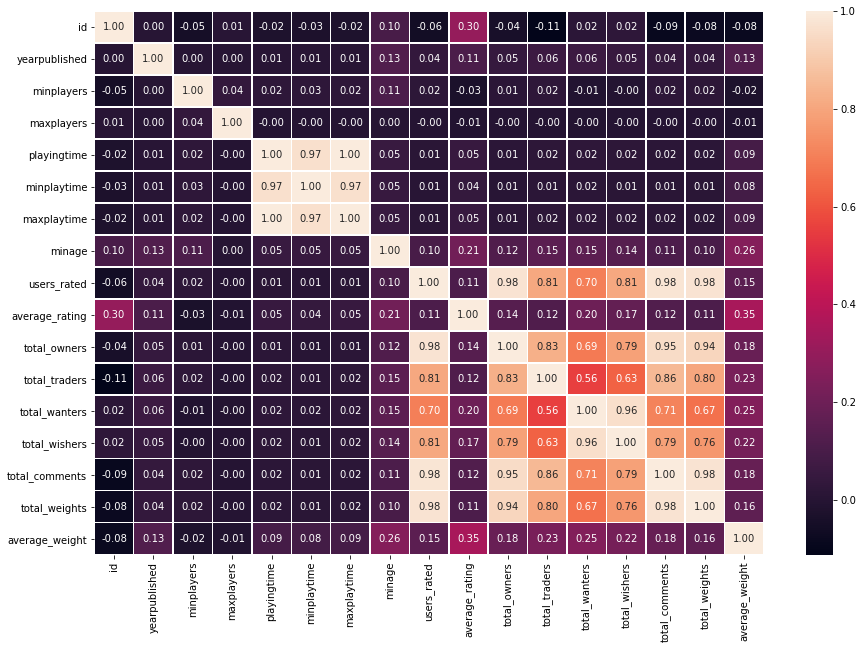

In [9]:
plt.figure(figsize=(15,10))
sns.heatmap(correlations,annot=True, fmt = ".2f",linewidths=0.5);

### Model Fitting

In [10]:
def prediction(x_train, x_test, y_train, y_test,model):
    """
    A function to train and returns the RMSE of a given model
    x_train : train data of x
    x_test : test data of x
    y_train : train data of target variable
    y_test : test data of target variable
    model : machine learning model
    """
    # Standardazing
    scaler = StandardScaler()
    X_train_sm = scaler.fit_transform(x_train)
    X_test_sm = scaler.transform(x_test)

    # Fitting model on train data 
    model.fit(X_train_sm,y_train)

    # predicting the test data
    predictions = model.predict(X_test_sm)

    # calculating the root mean squared error
    rmse = mean_squared_error(y_test,predictions,squared=False)
    return rmse

In [11]:
# Using Ordinary Least Squares 
def sm_OLS(x_train, x_test, y_train, y_test):
    """
    Calculates the Ordinary Least squares method using statsmodels.api.OLS()
    x_train : train data of x
    x_test : test data of x
    y_train : train data of target variable
    y_test : test data of target variable
    """
    scaler = StandardScaler()
    X_train_sm = scaler.fit_transform(x_train)
    X_train_sm = sm.add_constant(X_train_sm)
    X_test_sm = scaler.transform(x_test)
    X_test_sm = sm.add_constant(X_test_sm)
    reg = sm.OLS(y_train,X_train_sm).fit()
    predictions = reg.predict(X_test_sm)
    rmse = mean_squared_error(y_test,predictions,squared=False)
    return rmse

In [12]:
def rmse_kfold(kf,model= None,ols=False):
    """
    Calculates and returns the RMSE of KFold cross validation
    kf : KFold split
    model : machine learning model 
    ols : True if its to calculate using statsmodels.api.OLS()
    """
    rmse_kf = []
    for train_index, test_index in kf.split(bg_x):
        X_train, X_test = bg_x.iloc[train_index],bg_x.iloc[test_index]
        y_train, y_test = bg_y.iloc[train_index],bg_y.iloc[test_index]
        if ols:
            rmse_kf.append(sm_OLS(X_train,X_test,y_train,y_test))
        else:
            rmse = prediction(X_train,X_test,y_train,y_test,model)
            rmse_kf.append(rmse)
    return rmse_kf


In [13]:
bg = board_games.drop(["id","name","yearpublished","minplayers","maxplayers","playingtime","minplaytime","maxplaytime"],axis = 1)
bg.head()

,minage,users_rated,average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
0,13.0,20113,8.33774,26647,372,1219,5865,5347,2562,3.4785
1,12.0,14383,8.28798,16519,132,1586,6277,2526,1423,3.8939
2,12.0,9262,8.28994,12230,99,1476,5600,1700,777,3.7761
3,12.0,13294,8.20407,14343,362,1084,5075,3378,1642,4.1590
4,12.0,39883,8.14261,44362,795,861,5414,9173,5213,3.2943


In [14]:

bg_y = bg.pop("average_rating")
bg_x = bg

In [15]:
X_train,X_test,Y_train,Y_test = train_test_split(bg_x,bg_y,test_size = 0.3,random_state = 2120)

In [16]:
# Initialising the linear regression model
reg = LinearRegression()
print (f'RMSE using linear regression model : {prediction(X_train,X_test,Y_train,Y_test,reg)}')
# Performing 5-cross validation to analyze the model performance using KFold()
kf = KFold(n_splits=5,random_state=2120)
rmse_kf = rmse_kfold(kf,reg)
print (f'Mean RMSE of KFold CV (Linear Regression) : {np.mean(np.array(rmse_kf))}')
print (f'RMSE of KFold CV : {rmse_kf}' )


RMSE using linear regression model : 1.443860941375258
Mean RMSE of KFold CV (Linear Regression) : 1.7190822559352932
RMSE of KFold CV : [1.9431025109098898, 1.518120177659356, 1.5876190019653837, 1.5839784536230521, 1.9625911355187828]


In [17]:
print (f'RMSE using the Ordinary Least Squares method : {sm_OLS(X_train,X_test,Y_train,Y_test)}')
rmse_kf = rmse_kfold(kf,ols = True)
print (f'Mean RMSE of KFold CV (OLS) : {np.mean(np.array(rmse_kf))}')
print (f'RMSE of KFold CV (OLS) : {rmse_kf}' )

RMSE using the Ordinary Least Squares method : 1.443860941375258
Mean RMSE of KFold CV (OLS) : 1.7190822559352938
RMSE of KFold CV (OLS) : [1.9431025109098952, 1.5181201776593571, 1.5876190019653846, 1.5839784536230512, 1.96259113551878]


In [18]:
sgd = SGDRegressor(random_state = 2120)
print (f'RMSE using the SGDRegressor() : {prediction(X_train,X_test,Y_train,Y_test,sgd)}')
rmse_kf = rmse_kfold(kf,model=sgd)
print (f'Mean RMSE of KFold CV (SGDRegressor()) : {np.mean(np.array(rmse_kf))}')
print (f'RMSE of KFold CV (SGDRegressor()) : {rmse_kf}' )

RMSE using the SGDRegressor() : 1.445195013761181
Mean RMSE of KFold CV (SGDRegressor()) : 1.897279344963308
RMSE of KFold CV (SGDRegressor()) : [2.841835980947989, 1.5144177559282934, 1.583660729660144, 1.5816503060986782, 1.9648319521814361]


It seems that the cross validation is yielding slightly worse results than the individual models.

In [19]:
learning_rate = [0.1,0.01,0.001]
tolerance_val = [0.5,0.1,0.01]

for lr in learning_rate:
    for tol in tolerance_val:
        sgd = SGDRegressor(max_iter = 50000, tol = tol,learning_rate = 'constant',eta0 = lr,random_state=2120)
        print (f'For learning rate:{lr} and tolerance value:{tol}, RMSE = {prediction(X_train,X_test,Y_train,Y_test,sgd)}')

For learning rate:0.1 and tolerance value:0.5, RMSE = 1753292418632.4836
For learning rate:0.1 and tolerance value:0.1, RMSE = 1753292418632.4836
For learning rate:0.1 and tolerance value:0.01, RMSE = 1753292418632.4836
For learning rate:0.01 and tolerance value:0.5, RMSE = 26209344266.509754
For learning rate:0.01 and tolerance value:0.1, RMSE = 26209344266.509754
For learning rate:0.01 and tolerance value:0.01, RMSE = 26209344266.509754
For learning rate:0.001 and tolerance value:0.5, RMSE = 1.444677581469782
For learning rate:0.001 and tolerance value:0.1, RMSE = 1.4494212114338807
For learning rate:0.001 and tolerance value:0.01, RMSE = 1.4494212114338807


It might be that that when the step size is larger, the model is converging at a local minima instead of the global minima, as can be observed when the step size is smaller. With this, it is clear that even though the model may converge faster with a larger step size, it will not necessarily be better.

In [20]:
# Using LassoCV and measuring its RMSE
lasso = LassoCV(cv=5,random_state=2120)
l1_rmse = prediction(X_train,X_test,Y_train,Y_test,lasso)
print (f'RMSE for L1 regularization:{l1_rmse}')

RMSE for L1 regularization:1.4437063187654602


In [21]:
# Using RidgeCV and measuring its RMSE
ridge = RidgeCV(cv=5)
l2_rmse = prediction(X_train,X_test,Y_train,Y_test,ridge)
print (f'RMSE for L2 regularization:{l2_rmse}')

RMSE for L2 regularization:1.4438180355417625


From the given observation, Lasso performs slightly better than Ridge. We do not feel there is much difference between the two to make a clear distinction, but looking purely at the result, we would prefer to use Lasso over Ridge.

In [22]:
#Random Forest Regressor
ran_forest = RandomForestRegressor(n_estimators = 5, random_state = 2120)
print( f"RMSE of Random Forest Regressor Model : {prediction(X_train,X_test,Y_train,Y_test,ran_forest)}")
# Neural Networks
neu_net = MLPRegressor(random_state=2120, max_iter=500,hidden_layer_sizes=1)
print(f"RMSE of Neural Network Model with 1 hidden layer : {prediction(X_train,X_test,Y_train,Y_test,neu_net)}")

RMSE of Random Forest Regressor Model : 1.4167585065173771
RMSE of Neural Network Model with 1 hidden layer : 1.444623294578481


From the above results, we can see that Random forest Regressor model performs better than Neural Network Model with 1 hidden layer since RMSE of Random forest Regressor is less than that of Neural Network Model.